In [1]:
import pandas as pd
import seaborn as sns



In [2]:
tlc = pd.read_parquet("/Users/jiang/Desktop/fhvhv_tripdata_2024-01.parquet", engine='pyarrow')

In [3]:
pickUpID = tlc['PULocationID']
dropOffID = tlc['DOLocationID']

In [4]:
tlc_nta = pd.read_csv("taxi-zone-lookup-with-ntacode.csv")

In [5]:
pu_df = tlc.merge(tlc_nta, how="left", left_on='PULocationID', right_on="location_id")
do_df = tlc.merge(tlc_nta, how="left", left_on='DOLocationID', right_on="location_id")

In [6]:
nta = pd.read_csv("Neighborhood_Cleaned.csv")

In [7]:
nta['% Other'] = nta["% Other"].str[:-1].astype(float)

In [8]:
mrgd = tlc.merge(tlc_nta, how="left", left_on='PULocationID', right_on="location_id", suffixes=(None, "PU"))
mrgd = mrgd.merge(tlc_nta, how="left", left_on='DOLocationID', right_on="location_id", suffixes=(None, "DO"))

In [9]:
mrgd = mrgd.merge(nta, how="left", left_on='ntacode', right_on="NTA Code", suffixes=(None, "PU"))
mrgd = mrgd.merge(nta, how="left", left_on='ntacodeDO', right_on="NTA Code", suffixes=(None, "DO"))

In [10]:
mrgd.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'location_id', 'borough', 'zone',
       'service_zone', 'ntacode', 'location_idDO', 'boroughDO', 'zoneDO',
       'service_zoneDO', 'ntacodeDO',
       'Neighborhood Tabulation Area (NTA) Name', 'NTA Code', 'Boro Name',
       'Boro CD', 'Total Population', '65+ years', '%65+ yeras',
       '%65+ Below poverty', '% Hispanic/Latino', '% White',
       '% Black/African American', '% Asian', '% Other',
       'Neighborhood Tabulation Area (NTA) NameDO', 'NTA CodeDO',
       'Boro NameDO', 'Boro CDDO', 'Total PopulationDO',

In [11]:
mrgd = mrgd.drop(columns=['dispatching_base_num', 'originating_base_num',\
                          'location_id', 'service_zone', 'ntacode',\
                          'location_idDO', 'service_zoneDO', 'ntacodeDO',\
                          'NTA Code', 'NTA CodeDO'])

In [13]:
mrgd = mrgd.rename(columns={'hvfhs_license_num': 'Ride-Hailing Service Number',\
                            'request_datetime': 'Request Datetime',\
                            'on_scene_datetime': 'On-Scene Datetime',\
                            'pickup_datetime': 'Pick-Up Datetime',\
                            'dropoff_datetime': 'Drop-Off Datetime',\
                            'PULocationID': 'Pick-Up Location ID',\
                            'DOLocationID': 'Drop-Off Location ID',\
                            'trip_miles': 'Trip Distance (miles)',\
                            'trip_time': 'Trip Length (seconds)',\
                            'base_passenger_fare': 'Base Passenger Fare',\
                            'tolls': 'Toll Fare',\
                            'bcf': 'Black Car Fund Fare',\
                            'sales_tax': 'NYS Sales Tax Fare',\
                            'congestion_surcharge': 'NYS Congestion Surcharge',\
                            'airport_fee': 'Airport Fee',\
                            'tips': 'Tips Given',\
                            'driver_pay': 'Driver Pay',\
                            'shared_request_flag': 'Passenger Agreed to Share Ride', \
                            'shared_match_flag': 'Passenger Shared Ride',\
                            'access_a_ride_flag': 'Administered by MTA',\
                            'wav_request_flag': 'Passenger Requested WAV',\
                            'wav_match_flag': 'Passenger Rode in WAV'})


In [14]:
mrgd.columns

Index(['Ride-Hailing Service Number', 'Request Datetime', 'On-Scene Datetime',
       'Pick-Up Datetime', 'Drop-Off Datetime', 'Pick-Up Location ID',
       'Drop-Off Location ID', 'Trip Distance (miles)',
       'Trip Length (seconds)', 'Base Passenger Fare', 'Toll Fare',
       'Black Car Fund Fare', 'NYS Sales Tax Fare', 'NYS Congestion Surcharge',
       'Airport Fee', 'Tips Given', 'Driver Pay',
       'Passenger Agreed to Share Ride', 'Passenger Shared Ride',
       'Administered by MTA', 'Passenger Requested WAV',
       'Passenger Rode in WAV', 'borough', 'zone', 'boroughDO', 'zoneDO',
       'Neighborhood Tabulation Area (NTA) Name', 'Boro Name', 'Boro CD',
       'Total Population', '65+ years', '%65+ yeras', '%65+ Below poverty',
       '% Hispanic/Latino', '% White', '% Black/African American', '% Asian',
       '% Other', 'Neighborhood Tabulation Area (NTA) NameDO', 'Boro NameDO',
       'Boro CDDO', 'Total PopulationDO', '65+ yearsDO', '%65+ yerasDO',
       '%65+ Below p

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# 1. Load and Preprocess the Data
mrgd = mrgd.dropna()

# Create binary target: high_fare if Base Passenger Fare exceeds its median
fare_median = mrgd['Base Passenger Fare'].median()
mrgd['high_fare'] = (mrgd['Base Passenger Fare'] > fare_median).astype(int)

# Compute the cost per mile feature
# (Ensure that Trip Distance (miles) is not zero to avoid division errors)
mrgd['cost_per_mile'] = mrgd['Base Passenger Fare'] / mrgd['Trip Distance (miles)']
mrgd = mrgd[np.isfinite(mrgd['cost_per_mile'])]
# Define features: include the new cost_per_mile along with existing features
features = ['Trip Distance (miles)', 'Trip Length (seconds)', 'cost_per_mile']

# Define protected attributes for multiple ethnicities
ethnicities = {
    'Black': '% Black/African American',
    'Hispanic': '% Hispanic/Latino',
    'White': '% White',
    'Asian': '% Asian',
    'Other': '% Other'
}

for eth, col in ethnicities.items():
    median_val = mrgd[col].median()
    mrgd[f'protected_{eth.lower()}'] = (mrgd[col] > median_val).astype(int)

def compute_error_rates(y_true, y_pred, sensitive):
    """
    Computes the False Positive Rate (FPR) and False Negative Rate (FNR)
    for each subgroup defined by the sensitive attribute.
    Returns a dictionary with keys for each group (e.g., 0 and 1).
    """
    groups = np.unique(sensitive)
    rates = {}
    for g in groups:
        mask = (sensitive == g)
        y_true_group = y_true[mask]
        y_pred_group = y_pred[mask]
        tp = np.sum((y_true_group == 1) & (y_pred_group == 1))
        tn = np.sum((y_true_group == 0) & (y_pred_group == 0))
        fp = np.sum((y_true_group == 0) & (y_pred_group == 1))
        fn = np.sum((y_true_group == 1) & (y_pred_group == 0))
        # Avoid division by zero
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        rates[g] = {'FPR': fpr, 'FNR': fnr}
    return rates

results = []

for eth, col in ethnicities.items():
    sens_col = f'protected_{eth.lower()}'
    print(f"\nEvaluating for protected attribute: {eth} ({sens_col})")
    
    X = mrgd[features]
    y = mrgd['high_fare']
    A = mrgd[sens_col]
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
        X, y, A, test_size=0.3, random_state=42, stratify=y
    )
    
    # ----- Baseline Model -----
    baseline_clf = LogisticRegression(solver='liblinear')
    baseline_clf.fit(X_train, y_train)
    y_pred_baseline = baseline_clf.predict(X_test)

    baseline_acc = accuracy_score(y_test, y_pred_baseline)
    print(f"Baseline Accuracy: {baseline_acc:.3f}")
    
    baseline_rates = compute_error_rates(y_test.values, y_pred_baseline, A_test.values)
    baseline_fpr_disp = abs(baseline_rates[0]['FPR'] - baseline_rates[1]['FPR'])
    baseline_fnr_disp = abs(baseline_rates[0]['FNR'] - baseline_rates[1]['FNR'])
    
    results.append({
        'Ethnicity': eth,
        'Model': 'Baseline',
        'FPR_Disparity': baseline_fpr_disp,
        'FNR_Disparity': baseline_fnr_disp,
        'Accuracy': baseline_acc
    })
    
    # ----- Fairness-Aware Model (ExponentiatedGradient with Equalized Odds) -----
    constraint = EqualizedOdds()
    fair_clf = ExponentiatedGradient(
        estimator=LogisticRegression(solver='liblinear'),
        constraints=constraint,
        eps=0.01  # Adjust as needed
    )
    fair_clf.fit(X_train, y_train, sensitive_features=A_train)
    y_pred_fair = fair_clf.predict(X_test)
    
    fair_acc = accuracy_score(y_test, y_pred_fair)
    print(f"Fair Model Accuracy: {fair_acc:.3f}")
    
    fair_rates = compute_error_rates(y_test.values, y_pred_fair, A_test.values)
    fair_fpr_disp = abs(fair_rates[0]['FPR'] - fair_rates[1]['FPR'])
    fair_fnr_disp = abs(fair_rates[0]['FNR'] - fair_rates[1]['FNR'])
    
    results.append({
        'Ethnicity': eth,
        'Model': 'Fairness-Aware',
        'FPR_Disparity': fair_fpr_disp,
        'FNR_Disparity': fair_fnr_disp,
        'Accuracy': fair_acc
    })

results_df = pd.DataFrame(results)
print("\nComparison of Error Disparities and Accuracies:")
print(results_df)




Evaluating for protected attribute: Black (protected_black)
Baseline Accuracy: 0.909
Fair Model Accuracy: 0.877

Evaluating for protected attribute: Hispanic (protected_hispanic)
Baseline Accuracy: 0.909
Fair Model Accuracy: 0.874

Evaluating for protected attribute: White (protected_white)
Baseline Accuracy: 0.909
Fair Model Accuracy: 0.871

Evaluating for protected attribute: Asian (protected_asian)
Baseline Accuracy: 0.909
Fair Model Accuracy: 0.877

Evaluating for protected attribute: Other (protected_other)
Baseline Accuracy: 0.909
Fair Model Accuracy: 0.901

Comparison of Error Disparities and Accuracies:
  Ethnicity           Model  FPR_Disparity  FNR_Disparity  Accuracy
0     Black        Baseline       0.026338       0.055172  0.909471
1     Black  Fairness-Aware       0.007821       0.017443  0.877396
2  Hispanic        Baseline       0.026664       0.068627  0.909471
3  Hispanic  Fairness-Aware       0.008351       0.017824  0.874172
4     White        Baseline       0.0277

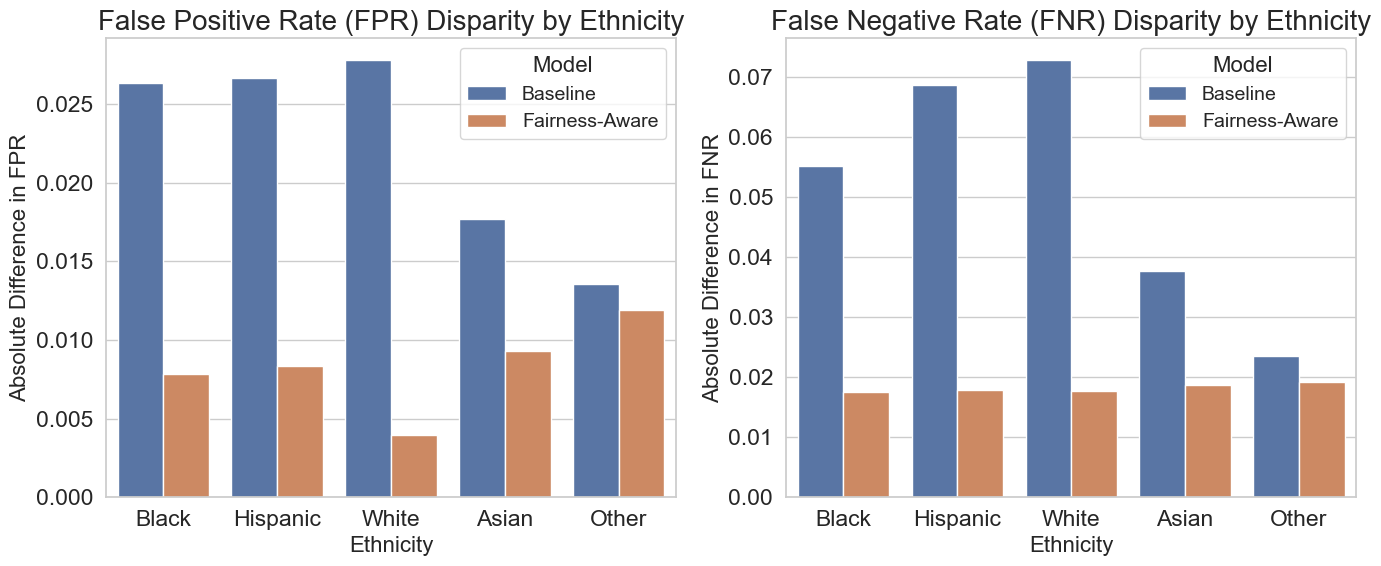

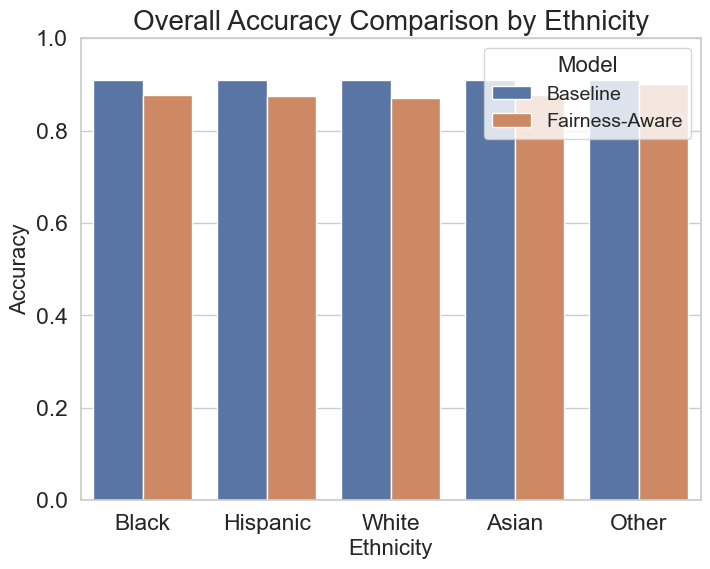

In [20]:
# Set a global font scale
sns.set(style="whitegrid", font_scale=1.5)

# Plotting FPR and FNR Disparities
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(
    data=results_df,
    x='Ethnicity',
    y='FPR_Disparity',
    hue='Model',
    ax=axes[0]
)
axes[0].set_title('False Positive Rate (FPR) Disparity by Ethnicity', fontsize=20)
axes[0].set_ylabel('Absolute Difference in FPR', fontsize=16)
axes[0].set_xlabel('Ethnicity', fontsize=16)
axes[0].legend(title='Model', fontsize=14, title_fontsize=16)

sns.barplot(
    data=results_df,
    x='Ethnicity',
    y='FNR_Disparity',
    hue='Model',
    ax=axes[1]
)
axes[1].set_title('False Negative Rate (FNR) Disparity by Ethnicity', fontsize=20)
axes[1].set_ylabel('Absolute Difference in FNR', fontsize=16)
axes[1].set_xlabel('Ethnicity', fontsize=16)
axes[1].legend(title='Model', fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.show()

# Plotting Overall Accuracy Comparison
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=results_df,
    x='Ethnicity',
    y='Accuracy',
    hue='Model'
)
ax.set_title('Overall Accuracy Comparison by Ethnicity', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_xlabel('Ethnicity', fontsize=16)
plt.ylim(0, 1)
plt.legend(title='Model', fontsize=14, title_fontsize=16)
plt.show()
